In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from classy import Class # import classy module

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=24)
rc('axes', labelsize=20)
rc('axes', axisbelow=False)
rc('lines',linewidth=2)
# lines.markersize : 10
rc('xtick', labelsize=16)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=16)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
rc('legend',fontsize='x-large')

#################################

# unfortunately autodiff currently needs double precision!
jax.config.update("jax_enable_x64", True) 

from pylinger_background import evolve_background
from pylinger_perturbations import evolve_one_mode, evolve_perturbations

In [2]:
## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
# OmegaDE = 1.0-Omegam
w_DE_0  = -0.99
w_DE_a  = 0.00
cs2_DE  = 0.99
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Neff    = 2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
H0      = 67.742
A_s     = 2.1064e-09
n_s     = 0.96822

kmin    = 1e-4
kmax    = 1e+1
num_k   = 256

aexp = jnp.geomspace(1e-4,1,256)

# list of parameters with respect to which we take derivatives
fieldnames = ['H_0', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'Y_{He}', 'A_s', 'n_s', 'w_0', 'w_a', 'c_s^2']
fiducial_cosmo_param = jnp.array([H0, Omegam, Omegab, Neff, mnu, Tcmb, YHe, A_s, n_s,  w_DE_0, w_DE_a, cs2_DE])


In [3]:
def Pk_of_cosmo( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    param = {}
    param['Omegam'] = args[1]
    param['Omegab'] = args[2]
    param['OmegaDE'] = 1-args[1]
    param['Omegak'] = 0.0
    A_s = args[7]
    n_s = args[8]
    param['H0'] = args[0]
    param['Tcmb'] = args[5]
    param['YHe'] = args[6]
    param['Neff'] = args[3]
    param['Nmnu'] = num_massive_neutrinos
    param['mnu'] = args[4]
    param['w_DE_0'] = args[9]
    param['w_DE_a'] = args[10]
    param['cs2_DE'] = args[11]

    k_p  = 0.05

    ## compute the background evolution
    param = evolve_background(param=param)
    

    # Compute Perturbations
    # lmaxg  = 12
    # lmaxgp = 12
    # lmaxr  = 17
    # lmaxnu = 17
    # nqmax  = 15

    rtol   = 1e-4
    atol   = 1e-4

    # Compute Perturbations
    # nmodes = 256  # number of modes to compute, reduce to speed up calculation
    # kmin = 1e-4
    # kmax = 1e1
    # aexp_out = jnp.array([1.0])
    aexp_out = jnp.copy(aexp) #jnp.geomspace(1e-3,1,256)

    y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=num_k, aexp_out=aexp_out,
                                    #   lmaxg=lmaxg, lmaxgp=lmaxgp, lmaxr=lmaxr, lmaxnu=lmaxnu, nqmax=nqmax,
                                       rtol=rtol, atol=atol )

    # iout = -1
    fac = 2 * jnp.pi**2 * A_s
    # Pkm = fac *(kmodes[:,None]/k_p)**(n_s - 1) * kmodes[:,None]**(-3) * y[:,:,9]**2   #total matter = cdm + baryon + massive neutrino
    # return Pkm
    Pkbc = fac *(kmodes[:,None]/k_p)**(n_s - 1) * kmodes[:,None]**(-3) * y[:,:,10]**2
    return Pkbc

In [15]:
def Pk_CLASS( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    # CLASS setup
    # create instance of the class "Class"
    LambdaCDM = Class()
    # pass input parameters
    LambdaCDM.set({
        'Omega_k':0.0,
        'Omega_b':args[2],
        'Omega_cdm':(args[1]-args[2]),
        'N_ur':args[3],
        'N_ncdm':num_massive_neutrinos,
        'm_ncdm':args[4],
        'h':args[0]/100,
        'A_s':args[7],
        'n_s':args[8],
        # 'tau_reio':0.06, 
        'gauge':'synchronous',
        'reio_parametrization' : 'reio_none',
        # 'k_per_decade_for_pk' : 100,
        # 'k_per_decade_for_bao' : 100,
        # 'compute damping scale' : 'yes',
        # 'tol_perturbations_integration' : 1e-07,
        # 'tol_background_integration' : 1e-07,
        # # 'hyper_flat_approximation_nu' : 7000,
        'T_cmb':args[5],
        'YHe':args[6],
        'output':'mPk',
        'lensing':'no',
        'P_k_max_1/Mpc': kmax*1.01,
        'z_max_pk':1000.0,
        # # these are high precision reference settings
        # 'start_small_k_at_tau_c_over_tau_h' : 0.0004,
        # 'start_large_k_at_tau_h_over_tau_k' : 0.05,
        # 'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
        # 'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
        # 'start_sources_at_tau_c_over_tau_h' : 0.006,
        # 'l_max_g' : 50,
        # 'l_max_pol_g' : 25,
        # 'l_max_ur' : 50,
        # 'l_max_ncdm' : 50,
        'Omega_Lambda' : 0.0,
        'w0_fld' : args[9],
        'wa_fld' : args[10],
        'cs2_fld' : args[11],
        'use_ppf' : 'no',
      })
    # run class
    LambdaCDM.compute()
    zout = 0.0
    # Pkm_CLASS = np.array([LambdaCDM.pk_lin(ki, zout) for ki in np.geomspace(kmin,kmax,num_k)])
    Pkm_CLASS = np.array([LambdaCDM.pk_cb_lin(ki, zout) for ki in np.geomspace(kmin,kmax,num_k)])
    return Pkm_CLASS

In [5]:

# # @eqx.filter_jit
# def fonek_of_Omegam( args, kmode ):
#     """
#     args:
#         0: Omegam
#         1: Omegab
#         2: A_s
#         3: n_s
#         4: H0
#         5: Tcmb
#         6: YHe
#         7: Neff
#         8: mnu
#     """
#     A_s = args[2]
#     n_s = args[3]
#     param = {}
#     param['Omegam'] = args[0]
#     param['Omegab'] = args[1]
#     param['OmegaL'] = 1-param['Omegam']
#     param['Omegak'] = 0.0
#     param['A_s'] = args[2]
#     param['n_s'] = args[3]
#     param['H0'] = args[4]
#     param['Tcmb'] = args[5]
#     param['YHe'] = args[6]
#     param['Neff'] = args[7]
#     param['Nmnu'] = 1
#     param['mnu'] = args[8]
#     param = evolve_background(param=param)
    
#     k = 1e-2

#     # Compute Perturbations
#     # lmaxg  = 12
#     # lmaxgp = 12
#     # lmaxr  = 17
#     # lmaxnu = 17
#     # nqmax  = 15

#     # rtol   = 1e-4
#     # atol   = 1e-4

#     # Compute Perturbations
#     # aexp_out = jnp.array([1e-2,1e-1]) 
#     aexp_out = jnp.geomspace(1e-5,1,128)
#     tau_out = jax.vmap( lambda a: param['tau_of_a_spline'].evaluate(a) )(aexp_out)

#     y = evolve_one_mode( param=param, kmode=kmode, tau_out=tau_out, tau_max=jnp.max(tau_out) )

#     k = kmode
#     return A_s*(k/k_p)**(n_s - 1) * k**(-3) * y**2 

In [6]:
## compute the jacobian 
k  = jnp.geomspace(kmin,kmax,num_k) # number of modes to compute, reduce to speed up calculation

dy = jax.jacfwd(Pk_of_cosmo)(fiducial_cosmo_param)
y  = Pk_of_cosmo( fiducial_cosmo_param )

In [16]:
def get_finite_difference_class( idx, feps=1e-3 ):
  eps = feps * fiducial_cosmo_param[idx]
  param_plus  = np.copy(fiducial_cosmo_param)
  param_plus[idx] += eps/2
  param_minus = np.copy(fiducial_cosmo_param)
  param_minus[idx] -= eps/2

  Pk_minus = Pk_CLASS( param_minus )
  Pk_plus = Pk_CLASS( param_plus )

  return (np.log(Pk_plus)-np.log(Pk_minus))/eps

dy_fd0 = np.zeros( (num_k, len(fiducial_cosmo_param) ) )
dy_fd1 = np.zeros( (num_k, len(fiducial_cosmo_param) ) )
# dy_fd2 = np.zeros( (num_k, len(fiducial_cosmo_param) ) )

for i in range( len(fiducial_cosmo_param) ):
  dy_fd0[:,i] = get_finite_difference_class( i, 1e-2 )
  dy_fd1[:,i] = get_finite_difference_class( i, 1e-3 )
  # dy_fd2[:,i] = get_finite_difference_class( i, 1e-4 )


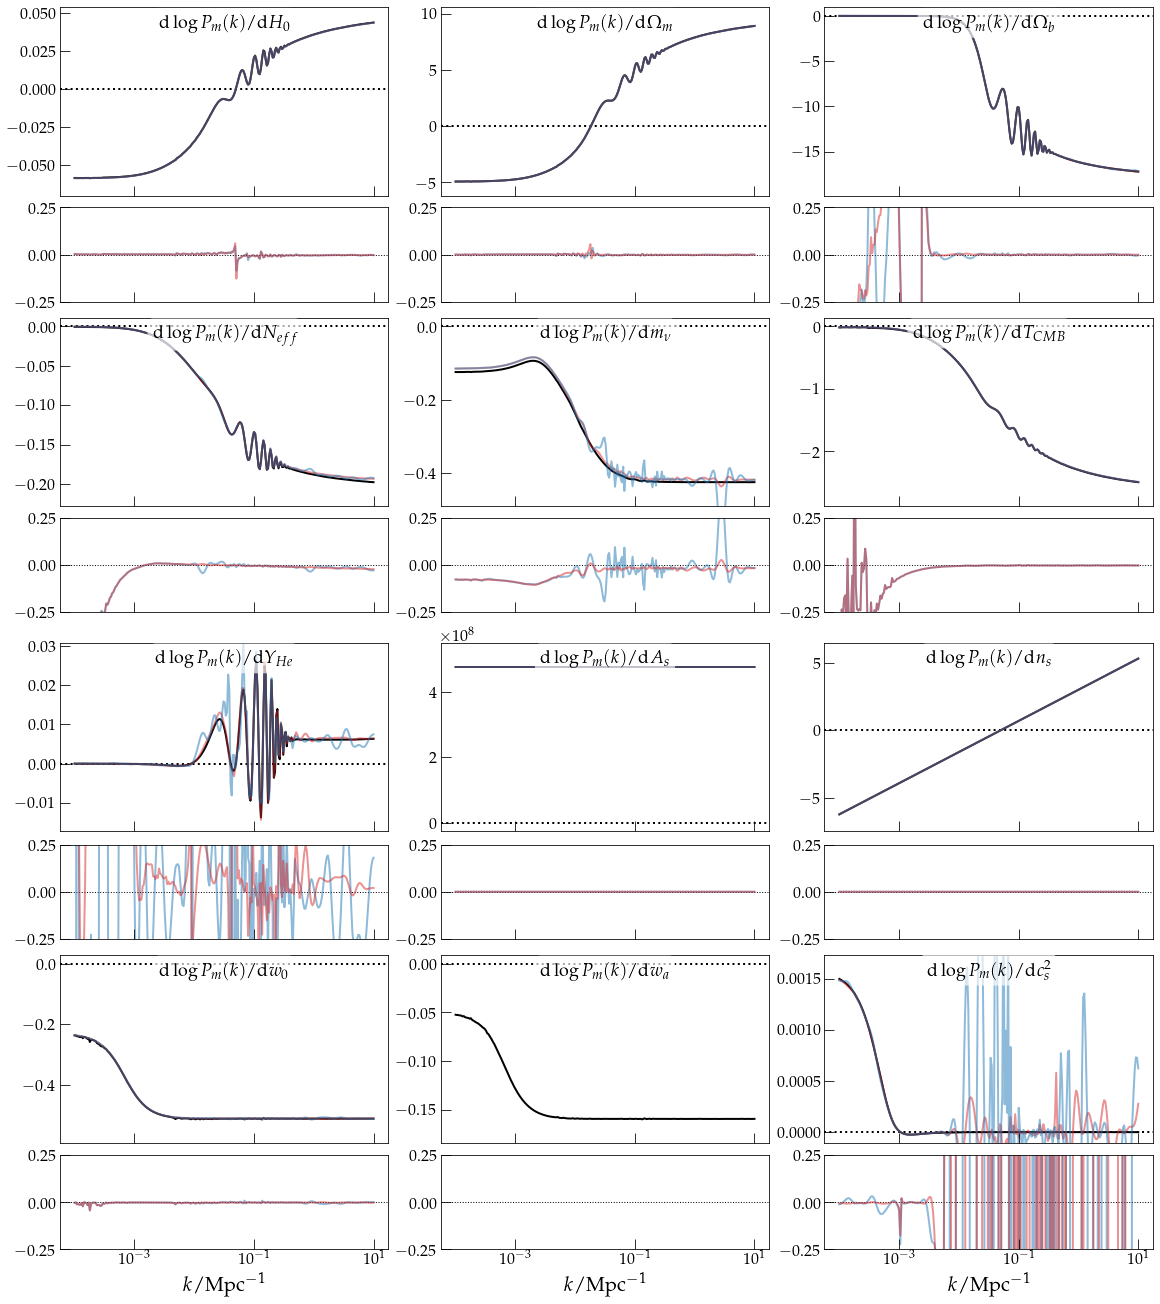

In [17]:
## make the plot
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -20  # pad is in points...

fig,ax = plt.subplots(8,3,sharex=True,figsize=(16,18),layout='constrained', gridspec_kw={'height_ratios': [2,1,2,1,2,1,2,1]})

title_bbox = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.667)



for i,ff in enumerate(fieldnames):
    iy = i%3
    ix = i//3
    dlogy = dy[:,-1,i]/y[:,-1]

    ax[2*ix,iy].axhline(0.0, ls=':', color='k')
    
    ax[2*ix,iy].semilogx(k, dlogy, label='$P_{m}$',c='k',lw=2)
    ylim = ax[2*ix,iy].get_ylim()

    ax[2*ix,iy].semilogx(k, dy_fd0[:,i],label='$P_{m}$',c='C3',lw=2,alpha=0.5)
    ax[2*ix,iy].semilogx(k, dy_fd1[:,i],label='$P_{m}$',c='C0',lw=2,alpha=0.5)
    # ax[2*ix,iy].semilogx(k, dy_fd2[:,i],label='$P_{m}$',c='C1',lw=3,alpha=0.75)

    
    # ax[2*ix,iy].semilogx(k, dlogy, label='$P_{m}$',c='k',lw=1)
    ax[2*ix,iy].set_ylim(ylim[0]*1.1,ylim[1]*1.1)
    # ax[ix,iy].semilogx(k, dy_fd2[:,i],label='$P_{m}$',c='C2',lw=2,alpha=0.75)
    
    ax[2*ix,iy].set_title(f'$\\mathrm{{d}} \\log P_{{m}}(k) / \\mathrm{{d}} {ff}$', bbox=title_bbox, fontsize=18)

    # ax[2*ix+1,iy].semilogx(k, dy_fd2[:,i]/dlogy-1.0, lw=2, c='C1')
    ax[2*ix+1,iy].axhline(0.0,ls=':',c='k',lw=1)
    ax[2*ix+1,iy].semilogx(k, dy_fd1[:,i]/dlogy-1.0, lw=2, c='C0',alpha=0.5)
    ax[2*ix+1,iy].semilogx(k, dy_fd0[:,i]/dlogy-1.0, lw=2, c='C3',alpha=0.5)
    
    ax[2*ix+1,iy].set_ylim(-0.25,0.25)
    
for a in ax[-1,:]:
    a.set_xlabel('$k / \\mathrm{Mpc}^{-1}$')

plt.savefig('derivatives_parameters.pdf')

In [18]:
# fig, ax = plt.subplots()

def plot_tile( ax, dlogy, title ):
  newax = fig.add_axes([0,1,0,1])#, frameon=False)
  im = newax.imshow( dlogy.T,cmap='RdBu_r', aspect='auto', extent=[0,1,0,1] ) #extent=[1e-3,1,1e-4,1]
  newax.set_autoscale_on(False)
  newax.set_in_layout(False)
  # newax.set_xticklabels([])
  # newax.set_yticklabels([])
  newax.axis('off')
  ax.set_zorder(1)
  newax.set_zorder(0.5)
  ax.patch.set_alpha(0.0)
  
  # ax.xaxis.set_major_formatter(fake_log)
  # ax.yaxis.set_major_formatter(fake_log)

  # ax.set_xscale('log')
  ax.loglog()
  ax.set_xlim(kmin,kmax)
  ax.set_ylim(np.min(aexp),np.max(aexp))
  ax.invert_yaxis()
  
  title_bbox = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.667)
  newax.set_title( title, bbox=title_bbox, fontsize=18)
  # newax.set_position( ax.get_position() )

  return newax, im

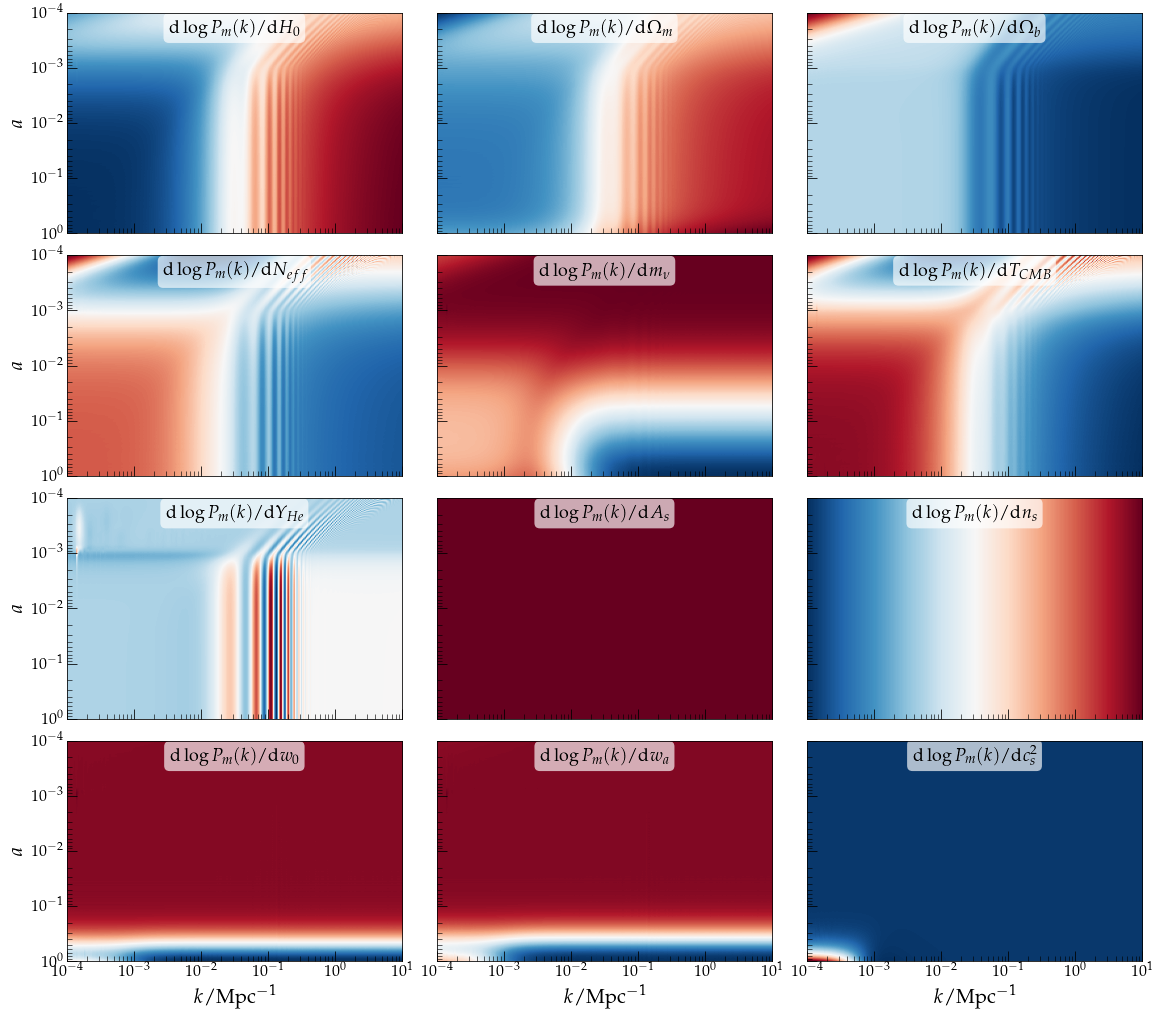

In [19]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -20  # pad is in points...

fig,ax = plt.subplots(4,3,sharex=True,sharey=True,figsize=(16,14),layout='constrained')

title_bbox = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.667)

m = np.zeros_like(ax)
ims = np.zeros_like(ax)
for i,ff in enumerate(fieldnames):
    iy = i%3
    ix = i//3
    dlogy = dy[...,i]/y
    # # m[ix,iy] = ax[ix,iy].pcolormesh( k, aexp, (dy[...,i]/y).T, cmap='RdBu_r' )
    # m[ix,iy] = ax[ix,iy].imshow( dlogy.T, extent=[1e-3,1,1e-4,1],vmin=np.min(dlogy.flatten()),vmax=np.max(dlogy.flatten()),cmap='RdBu_r', aspect='auto')
    # ax[ix,iy].set_title(f'$\\mathrm{{d}} \\log P_{{m}}(k) / \\mathrm{{d}} {ff}$', bbox=title_bbox, fontsize=18)
    # # ax[ix,iy].loglog()
    # ax[ix,iy].set_xscale('log')
    # ax[ix,iy].set_yscale('log')
    # # ax[ix,iy].set_aspect(1)
    # # ax.plot( dy[:,-1,0]/y[:,-1] )

    m[ix,iy], ims[ix,iy] = plot_tile( ax[ix,iy], dlogy, f'$\\mathrm{{d}} \\log P_{{m}}(k) / \\mathrm{{d}} {ff}$')

for a in ax[-1,:]:
    a.set_xlabel('$k / \\mathrm{Mpc}^{-1}$')


for a in ax[:,0]:
    a.set_ylabel('$a$')

for a in ax.flatten():
    a.set_ylim(np.max(aexp), np.min(aexp))

fig.canvas.draw()

for aa,mm in zip(ax.flatten(),m.flatten()):
    mm.set_position( aa.get_position(original=False), which='active' )
    mm.set_position( aa.get_position(original=True), which='original' )

ims[2,1].set_clim(-1,1)
plt.savefig('derivatives_spacetime.pdf')

In [11]:
# fig,ax = plt.subplots(3,3,sharex=True,figsize=(9,8),layout='constrained')
# for i in range(3):
#     for j in range(3):
#         ax[i,j].semilogx(k, dy[3*i+j][:,0,5],label='$P_b$')
#         ax[i,j].semilogx(k, dy[3*i+j][:,0,3],label='$P_c$')
#         ax[i,j].set_title(f'$d P(k) / d{cosmo_param_names[3*i+j]}$')
              
# ax[0,0].legend()

# for i in range(3):
#     ax[2,i].set_xlabel('$k$')

# plt.savefig('diff_Pk.pdf',bbox_inches='tight')


In [12]:
# ## compute the Jacobian for one k, but for many times
# kk = 1e-2
# aexp_out = jnp.geomspace(1e-5,1,128)
# dyonek = jax.jacfwd(fonek_of_Omegam)(fiducial_cosmo_param,kk)

In [13]:
# fig,ax = plt.subplots(3,3,sharex=True,figsize=(9,8),layout='constrained')
# for i in range(3):
#     for j in range(3):
#         ax[i,j].loglog( aexp_out, np.abs(dyonek[3*i+j][:,5]),label='$P_b$')
#         ax[i,j].loglog( aexp_out, np.abs(dyonek[3*i+j][:,3]),label='$P_c$')
#         ax[i,j].set_title(f'$d P(a) / d{cosmo_param_names[3*i+j]}$')

# ax[0,0].legend()

# for i in range(3):
#     ax[2,i].set_xlabel('$a$')

# fig.suptitle(f'$k = {kk} h^{{-1}}{{\\rm Mpc}}$')

# plt.savefig('diff_Pa.pdf',bbox_inches='tight')

In [14]:
dlogy

Array([[-2.47054054e-16, -6.16311023e-16, -1.18724179e-15, ...,
         1.28696194e-03,  1.39168856e-03,  1.50132333e-03],
       [-2.46756719e-16, -6.11633342e-16, -1.17484874e-15, ...,
         1.28167502e-03,  1.38563840e-03,  1.49462969e-03],
       [-2.46574567e-16, -6.07161019e-16, -1.16279133e-15, ...,
         1.27535117e-03,  1.37915272e-03,  1.48760386e-03],
       ...,
       [-3.26091743e-15, -5.14099651e-15, -7.02093955e-15, ...,
        -1.46063560e-12, -1.52867668e-12, -1.59779118e-12],
       [ 1.53432234e-14,  1.73118184e-14,  1.95764284e-14, ...,
        -1.23965901e-12, -1.30175538e-12, -1.36488364e-12],
       [ 7.67942300e-14,  8.17769122e-14,  8.67050467e-14, ...,
        -1.00564504e-12, -1.06238937e-12, -1.12004447e-12]],      dtype=float64)